In [395]:
# importing general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# importing model-related libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, make_scorer
from xgboost import XGBClassifier
from xgboost import plot_tree
import shap
shap.initjs()



#### Step 1. Loading and Invistigating the Dataset
_____

In [396]:
# loading the data set
df = pd.read_csv('predictive_maintenance.csv')
df

UDI Product ID Type  Air temperature [K]  Process temperature [K]   
0         1     M14860    M                298.1                    308.6  \
1         2     L47181    L                298.2                    308.7   
2         3     L47182    L                298.1                    308.5   
3         4     L47183    L                298.2                    308.6   
4         5     L47184    L                298.2                    308.7   
...     ...        ...  ...                  ...                      ...   
9995   9996     M24855    M                298.8                    308.4   
9996   9997     H39410    H                298.9                    308.4   
9997   9998     M24857    M                299.0                    308.6   
9998   9999     H39412    H                299.0                    308.7   
9999  10000     M24859    M                299.0                    308.7   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target   
0                       1551         42.8                0       0  \
1                       1408         46.3                3       0   
2                       1498         49.4                5       0   
3                       1433         39.5                7       0   
4                       1408         40.0                9       0   
...                      ...          ...              ...     ...   
9995                    1604         29.5               14       0   
9996                    1632         31.8               17       0   
9997                    1645         33.4               22       0   
9998                    1408         48.5               25       0   
9999                    1500         40.2               30       0   

     Failure Type  
0      No Failure  
1      No Failure  
2      No Failure  
3      No Failure  
4      No Failure  
...           ...  
9995   No Failure  
9996   No Failure  
9997   No Failure  
9998   No Failure  
9999   No Failure  

[10000 rows x 10 columns]

In [397]:
#dropping the UDI column
df.drop(columns=['UDI'], inplace=True)

In [398]:
pd.DataFrame([[df.shape],[df.isnull().sum().sum()],[df.duplicated().sum()]],
                columns=['Data Set'], index=['Shape', 'Missings', 'Duplicates'])

Data Set
Shape       (10000, 9)
Missings             0
Duplicates           0

In [399]:
# checking for repeated lead ids
n = len(pd.unique(df.index))
duplicates_lead = len(df.index) - n
  
print("No.of.unique lead id values :", 
      n)
print ("Number of duplicated leads :", duplicates_lead)

No.of.unique lead id values : 10000
Number of duplicated leads : 0


- So there is no duplicated row in the dataset

In [400]:
# checking for column types
df.dtypes

Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object

In [401]:
# set numeric columns dtype to float
df['Tool wear [min]'] = df['Tool wear [min]'].astype('float64')
df['Rotational speed [rpm]'] = df['Rotational speed [rpm]'].astype('float64')
# rename features
df.rename(mapper={'Product ID': 'product_id',
                    'Type': 'type',
                    'Air temperature [K]': 'air_temp',
                    'Process temperature [K]': 'process_temp',
                    'Rotational speed [rpm]': 'rotational_speed',
                    'Torque [Nm]': 'torque',
                    'Tool wear [min]': 'tool_wear',
                    'Target': 'target',
                    'Failure Type': 'failed_type'}, axis=1, inplace=True)

#### Step 2. EDA
_____

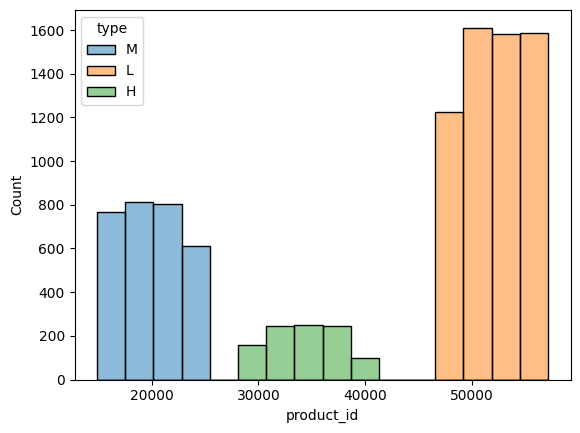

In [402]:
# remove first character and set to numeric column type
df['product_id'] = df['product_id'].apply(lambda x: x[1:])
df['product_id'] = pd.to_numeric(df['product_id'])

# # histogram of Product ID
sns.histplot(data=df, x='product_id', hue='type')
plt.show()

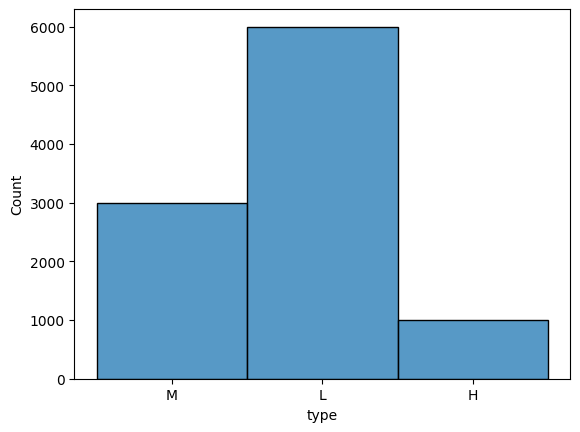

In [403]:
# # histogram of Type
sns.histplot(data=df, x='type')
plt.show()

In [404]:
# dropping product_id column
df.drop(columns=['product_id'], inplace=True) 

In [405]:
# Finding the share of each Type 
ratio = df['type'].value_counts()
type_share = 100*ratio/len(df)
type_share

type
L    60.00
M    29.97
H    10.03
Name: count, dtype: float64

In [406]:
type_share

type
L    60.00
M    29.97
H    10.03
Name: count, dtype: float64

In [407]:
# counting number of each failures
df['failed_type'].value_counts()

failed_type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

In [408]:
# droping the rows failed_type = 'Random Failure" 
## we do that as it comes from the name the random failures are not predictible by the model hence droping them to prevent the noise in the model
drop_index = df.loc[df['failed_type'] == 'Random Failures'].index
df.drop(index=drop_index, inplace=True)

# counting number of each failures to check the correctness of the drop function
df['failed_type'].value_counts()

failed_type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Name: count, dtype: int64

In [409]:
# counting number of each failures to check the correctness of the drop function
df['failed_type'].value_counts()

failed_type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Name: count, dtype: int64

In [410]:
# checking for abnormality in the data
abnorm = len(df.loc[(df['target']==1) & (df['failed_type']=='No Failure')])
print('Number of ambiguous observations:', abnorm)


Number of ambiguous observations: 9


In [411]:
# as we have 9 wrong cases we will drop them as well
drop_index2 = df.loc[(df['target']==1) & (df['failed_type']=='No Failure')].index
df.drop(index=drop_index2, inplace=True)

In [412]:
len(drop_index)

18

In [413]:
# share of removed observations
print('share of removed observations:', (100*(len(drop_index)+len(drop_index2))/n))
# reset index
df.reset_index(drop=True, inplace=True)
df

share of removed observations: 0.27


type  air_temp  process_temp  rotational_speed  torque  tool_wear   
0       M     298.1         308.6            1551.0    42.8        0.0  \
1       L     298.2         308.7            1408.0    46.3        3.0   
2       L     298.1         308.5            1498.0    49.4        5.0   
3       L     298.2         308.6            1433.0    39.5        7.0   
4       L     298.2         308.7            1408.0    40.0        9.0   
...   ...       ...           ...               ...     ...        ...   
9968    M     298.8         308.4            1604.0    29.5       14.0   
9969    H     298.9         308.4            1632.0    31.8       17.0   
9970    M     299.0         308.6            1645.0    33.4       22.0   
9971    H     299.0         308.7            1408.0    48.5       25.0   
9972    M     299.0         308.7            1500.0    40.2       30.0   

      target failed_type  
0          0  No Failure  
1          0  No Failure  
2          0  No Failure  
3          0  No Failure  
4          0  No Failure  
...      ...         ...  
9968       0  No Failure  
9969       0  No Failure  
9970       0  No Failure  
9971       0  No Failure  
9972       0  No Failure  

[9973 rows x 8 columns]

In [414]:
# looking for outliers
df.describe()

air_temp  process_temp  rotational_speed       torque    tool_wear   
count  9973.000000   9973.000000       9973.000000  9973.000000  9973.000000  \
mean    300.003259    310.004031       1538.893212    39.978993   107.921087   
std       2.000548      1.483692        179.412171     9.966805    63.649152   
min     295.300000    305.700000       1168.000000     3.800000     0.000000   
25%     298.300000    308.800000       1423.000000    33.200000    53.000000   
50%     300.100000    310.100000       1503.000000    40.100000   108.000000   
75%     301.500000    311.100000       1612.000000    46.700000   162.000000   
max     304.500000    313.800000       2886.000000    76.600000   253.000000   

            target  
count  9973.000000  
mean      0.033089  
std       0.178879  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000

- At the first glance we can see the difference between max and third quartile for rotational_speed, torque, and tool_wear is higher than usual so they can be the outliers candidates. For more closer observation the next step is to draw histogram and box plots of variables

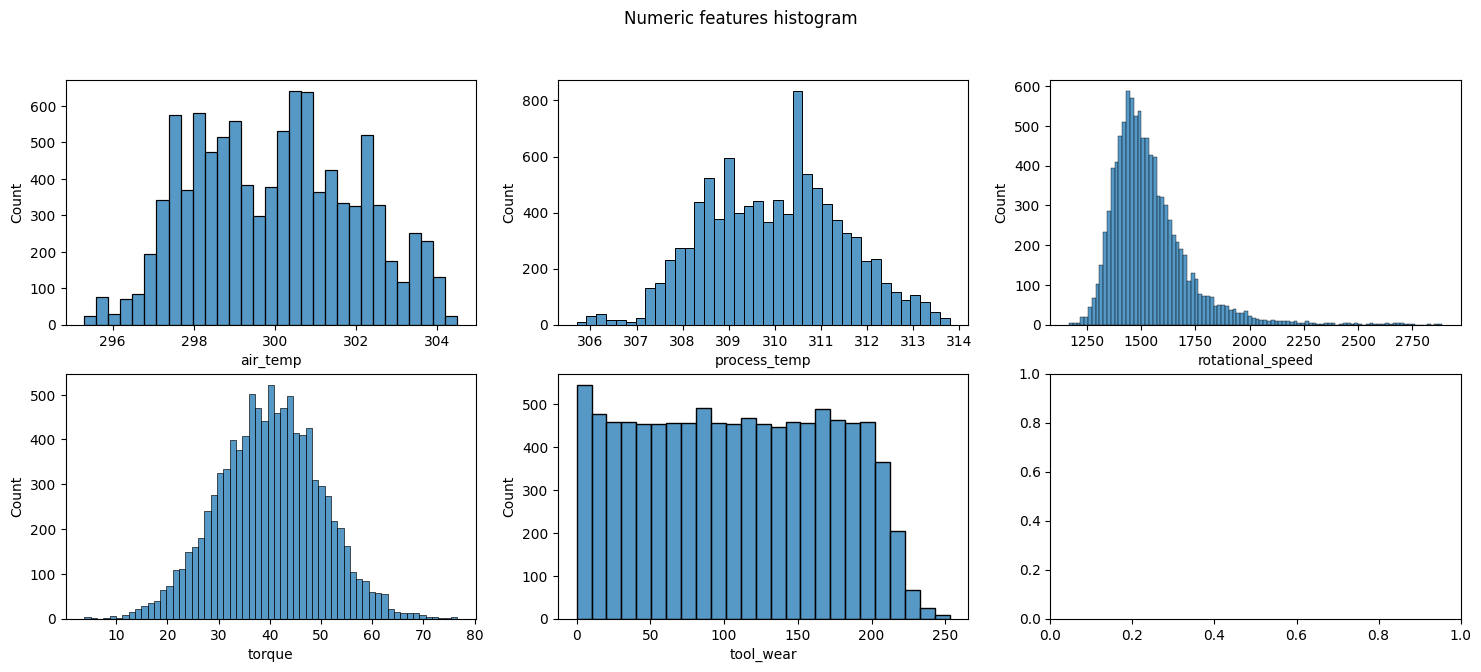

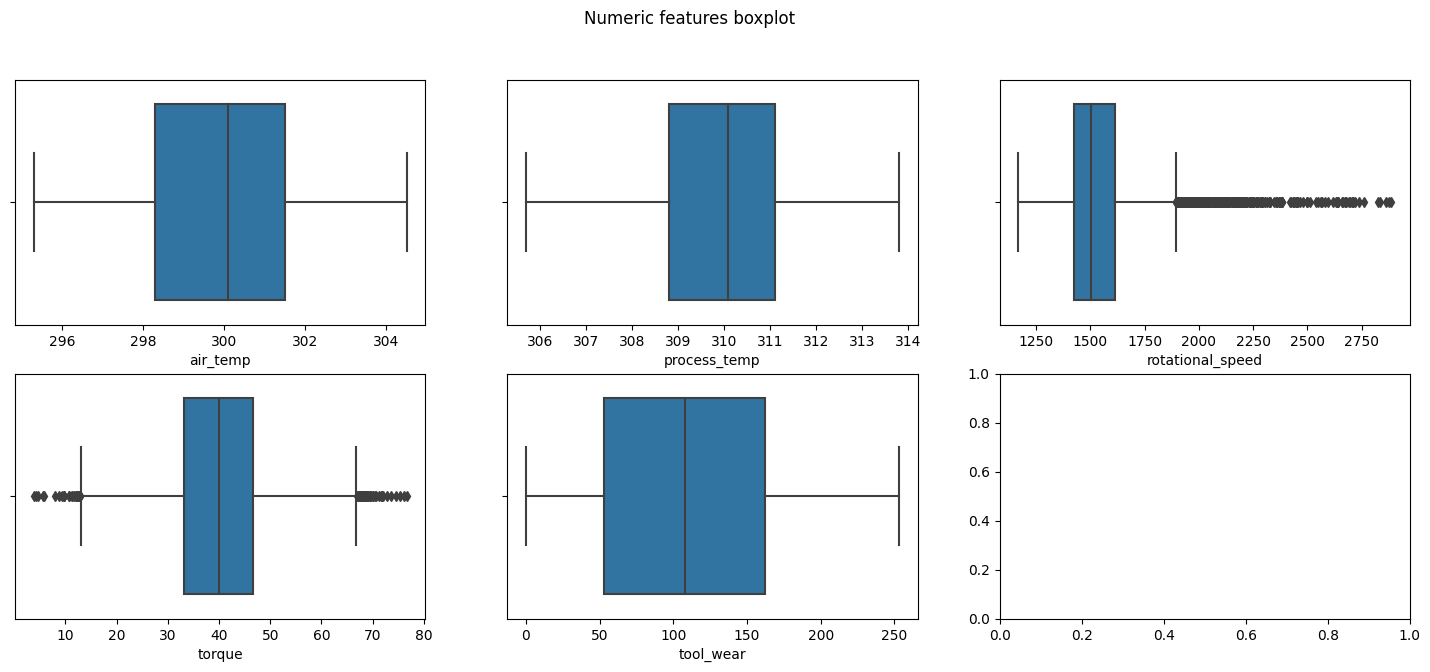

In [415]:
# Create lists of features and target names
features = [col for col in df.columns if df[col].dtype=='float64' or col =='Type']
num_features = [feature for feature in features if df[feature].dtype=='float64']
# Histograms of numeric features
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Numeric features histogram')
for j, feature in enumerate(num_features):
    sns.histplot(ax=axs[j//3, j-3*(j//3)], data=df, x=feature)
plt.show()

# boxplot of numeric features
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Numeric features boxplot')
for j, feature in enumerate(num_features):
    sns.boxplot(ax=axs[j//3, j-3*(j//3)], data=df, x=feature)
plt.show()

- Above graphs illustrate that columns rotational_speed (skewed to the right) and torque (in both tails) have outliers but:
    * In the case of torque as we can see the normal distribution and outliers at the end of both tails, we can't conclude that they are outliers by only using (max- 3rd quantile rule).
    * In case of Rotational Speed as it is possible that some machines actually exprienced high speed and hence maybe failed, we should better keep them as well.

#### Step 3. Checking Imbalances in Data
_____
- As we are dealing with multicalss classification problem. We should first analyze the share of each class compare to total observation, major class (No Failure), and among failed types

Failures percentage in data: 3.31


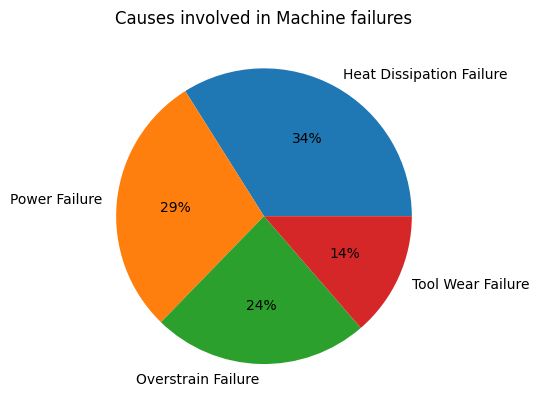

In [416]:
# Portion of df where there is a failure and causes percentage
n_final_observation = len(df)
idx_fail = df.loc[df['failed_type'] != 'No Failure'].index
df_fail = df.loc[idx_fail]
df_fail_percentage = 100*df_fail['failed_type'].value_counts()/df_fail['failed_type'].shape[0]
print('Failures percentage in data:',
      round(100*df['target'].sum()/n_final_observation,2))
# Pie plot
plt.title('Causes involved in Machine failures')
plt.pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
plt.show()

In [417]:
df['failed_type'].value_counts()

failed_type
No Failure                  9643
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Name: count, dtype: int64

In [418]:
cols = ['# of Observations', 'Share to Total (in %)', 'Share to No Failure (in %)']
rows = ['No Failure', 'Heat Dissipation Failure', 'Power Failure','Overstrain Failure ','Tool Wear Failure ']
data = [[9643,96.69,100], [112, 1.12, 1.16], [95, 0.95, 0.98], [78, 0.78, 0.81], [45,0.45,0.47]]
pd.DataFrame(data, index=rows, columns=cols)

# of Observations  Share to Total (in %)   
No Failure                             9643                  96.69  \
Heat Dissipation Failure                112                   1.12   
Power Failure                            95                   0.95   
Overstrain Failure                       78                   0.78   
Tool Wear Failure                        45                   0.45   

                          Share to No Failure (in %)  
No Failure                                    100.00  
Heat Dissipation Failure                        1.16  
Power Failure                                   0.98  
Overstrain Failure                              0.81  
Tool Wear Failure                               0.47

#### Step 4 - Handling Categorical Variables & Scaling the Numerical Variables
_____

In [419]:
# First we hard code the Failure Type and Type columns into numerical values to later on fir it to the model
df['failed_type'] = df['failed_type'].replace(['No Failure', 'Heat Dissipation Failure', 'Power Failure','Overstrain Failure','Tool Wear Failure'], [0, 1, 2, 3, 4])
df['type'] = df['type'].replace(['L', 'M', 'H'], [0, 1, 2])
df

type  air_temp  process_temp  rotational_speed  torque  tool_wear   
0        1     298.1         308.6            1551.0    42.8        0.0  \
1        0     298.2         308.7            1408.0    46.3        3.0   
2        0     298.1         308.5            1498.0    49.4        5.0   
3        0     298.2         308.6            1433.0    39.5        7.0   
4        0     298.2         308.7            1408.0    40.0        9.0   
...    ...       ...           ...               ...     ...        ...   
9968     1     298.8         308.4            1604.0    29.5       14.0   
9969     2     298.9         308.4            1632.0    31.8       17.0   
9970     1     299.0         308.6            1645.0    33.4       22.0   
9971     2     299.0         308.7            1408.0    48.5       25.0   
9972     1     299.0         308.7            1500.0    40.2       30.0   

      target  failed_type  
0          0            0  
1          0            0  
2          0            0  
3          0            0  
4          0            0  
...      ...          ...  
9968       0            0  
9969       0            0  
9970       0            0  
9971       0            0  
9972       0            0  

[9973 rows x 8 columns]

In [420]:
# using Standard Scaler to scale all numerival variables
sc = StandardScaler()
df_scaled = df.copy()
df_scaled[num_features] = sc.fit_transform(df_scaled[num_features]) 
df_scaled

type  air_temp  process_temp  rotational_speed    torque  tool_wear   
0        1 -0.951417     -0.946356          0.067484  0.283054  -1.695647  \
1        0 -0.901428     -0.878954         -0.729604  0.634238  -1.648511   
2        0 -0.951417     -1.013759         -0.227940  0.945286  -1.617087   
3        0 -0.901428     -0.946356         -0.590253 -0.048061  -1.585664   
4        0 -0.901428     -0.878954         -0.729604  0.002108  -1.554240   
...    ...       ...           ...               ...       ...        ...   
9968     1 -0.601495     -1.081162          0.362908 -1.051442  -1.475680   
9969     2 -0.551506     -1.081162          0.518981 -0.820665  -1.428545   
9970     1 -0.501517     -0.946356          0.591443 -0.660124  -1.349985   
9971     2 -0.501517     -0.878954         -0.729604  0.854982  -1.302849   
9972     1 -0.501517     -0.878954         -0.216792  0.022175  -1.224290   

      target  failed_type  
0          0            0  
1          0            0  
2          0            0  
3          0            0  
4          0            0  
...      ...          ...  
9968       0            0  
9969       0            0  
9970       0            0  
9971       0            0  
9972       0            0  

[9973 rows x 8 columns]

#### Step 5. Creating Train and Test Set
____

In [421]:
# for Train and Test data set we use (70/30 split), We also only use failed_type for multiclass classification as we rae interested to know on types of failures rather success/failure
X,y = df_scaled[features] , df_scaled['failed_type']
X.shape, y.shape


((9973, 5), (9973,))

In [422]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6981, 5), (6981,), (2992, 5), (2992,))

#### Step 6. Modeling
_____
- In this step we use only XGBoost model as according to studies, XGBoost always had a better performance in classification problem compare to other classification models (e.g. Logistic Regression, KNN, SVC, and Random Forest)
    * For refrence: https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d

In [423]:
# for addressing the issue of imbalance classes, we use below function to get the sample_weights for each class

def CreateBalancedSampleWeights(y_train, largest_class_weight_coef):
    classes = np.unique(y_train, axis = 0)
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in y_train]
    return sample_weights


In [424]:
# weight of success category to total observation
largest_class_weight_coef = max(df['failed_type'].value_counts().values)/df.shape[0]
largest_class_weight_coef
    
#pass y_train as numpy array
y_train_array = y_train.to_numpy().ravel()
sample_weight = CreateBalancedSampleWeights(y_train_array, largest_class_weight_coef)
sample_weight

[0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 0.2071513353115727,
 22.161904761

In [425]:
# Naive Model
model = XGBClassifier(objective='multi:softproba', num_class=5, seed= 42)

In [426]:
model.fit(X_train, y_train, sample_weight=sample_weight)
y_pred_train = model.predict(X_train)
y_pred_train

array([0, 0, 0, ..., 4, 0, 0])

In [427]:
def eval_preds(model,X,y_true,y_pred):
    cm = confusion_matrix(y_true, y_pred)
    proba = model.predict_proba(X)
    # Metrics
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, proba, multi_class='ovr', average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    f2 = fbeta_score(y_true, y_pred, beta=2, average='weighted')
    metrics = pd.Series(data={'ACC':acc, 'AUC':auc, 'F1':f1, 'F2':f2})
    metrics = round(metrics,3)
    return cm, metrics

Train set metrics:
ACC    0.999
AUC    1.000
F1     0.999
F2     0.999
dtype: float64


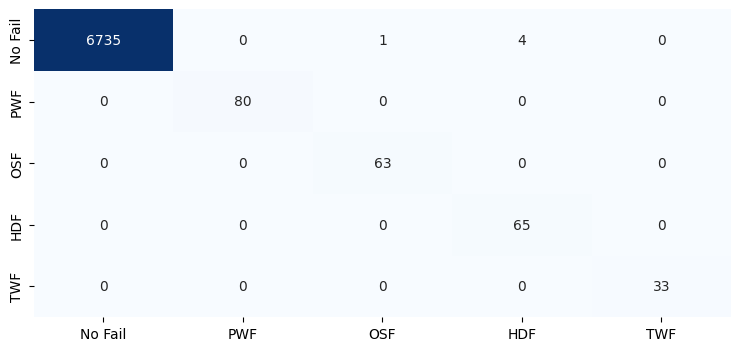

In [428]:
cm_train, metrics_train = eval_preds(model,X_train,y_train, y_pred_train)
print('Train set metrics:',metrics_train, sep='\n')

cm_labels = ['No Fail','PWF','OSF','HDF','TWF']
# Show Confusion Matrices
fig, axs = plt.subplots(ncols=1, figsize=(9,4))
sns.heatmap(ax=axs, data=cm_train, annot=True, fmt='d', cmap='Blues', cbar=False)
axs.set_xticklabels(cm_labels)
axs.set_yticklabels(cm_labels)
plt.show()

In [429]:
y_train.value_counts()

failed_type
0    6740
1      80
3      65
2      63
4      33
Name: count, dtype: int64

#### Step 7. Understanding the Effects of Features on Model Performance Using SHAP 
_____
For Refrence: 
* https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
* https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d


Test set metrics:
ACC    0.981
AUC    0.983
F1     0.983
F2     0.982
dtype: float64


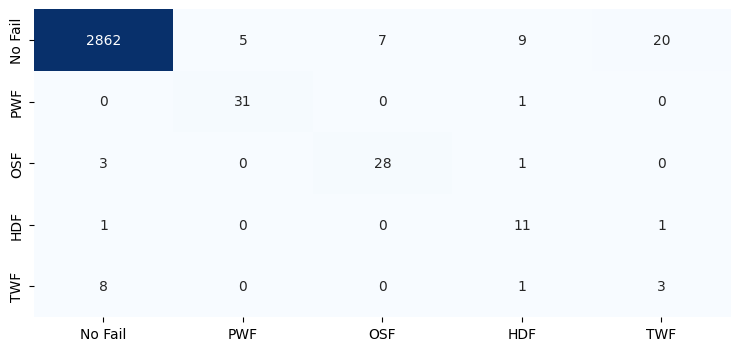

In [430]:
y_pred_test = model.predict(X_test)
cm_test, metrics_test = eval_preds(model,X_test,y_test, y_pred_test)
print('Test set metrics:',metrics_test, sep='\n')

cm_labels = ['No Fail','PWF','OSF','HDF','TWF']
# Show Confusion Matrices
fig, axs = plt.subplots(ncols=1, figsize=(9,4))
sns.heatmap(ax=axs, data=cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
axs.set_xticklabels(cm_labels)
axs.set_yticklabels(cm_labels)
plt.show()

In [431]:
y_test.value_counts()

failed_type
0    2903
1      32
2      32
3      13
4      12
Name: count, dtype: int64

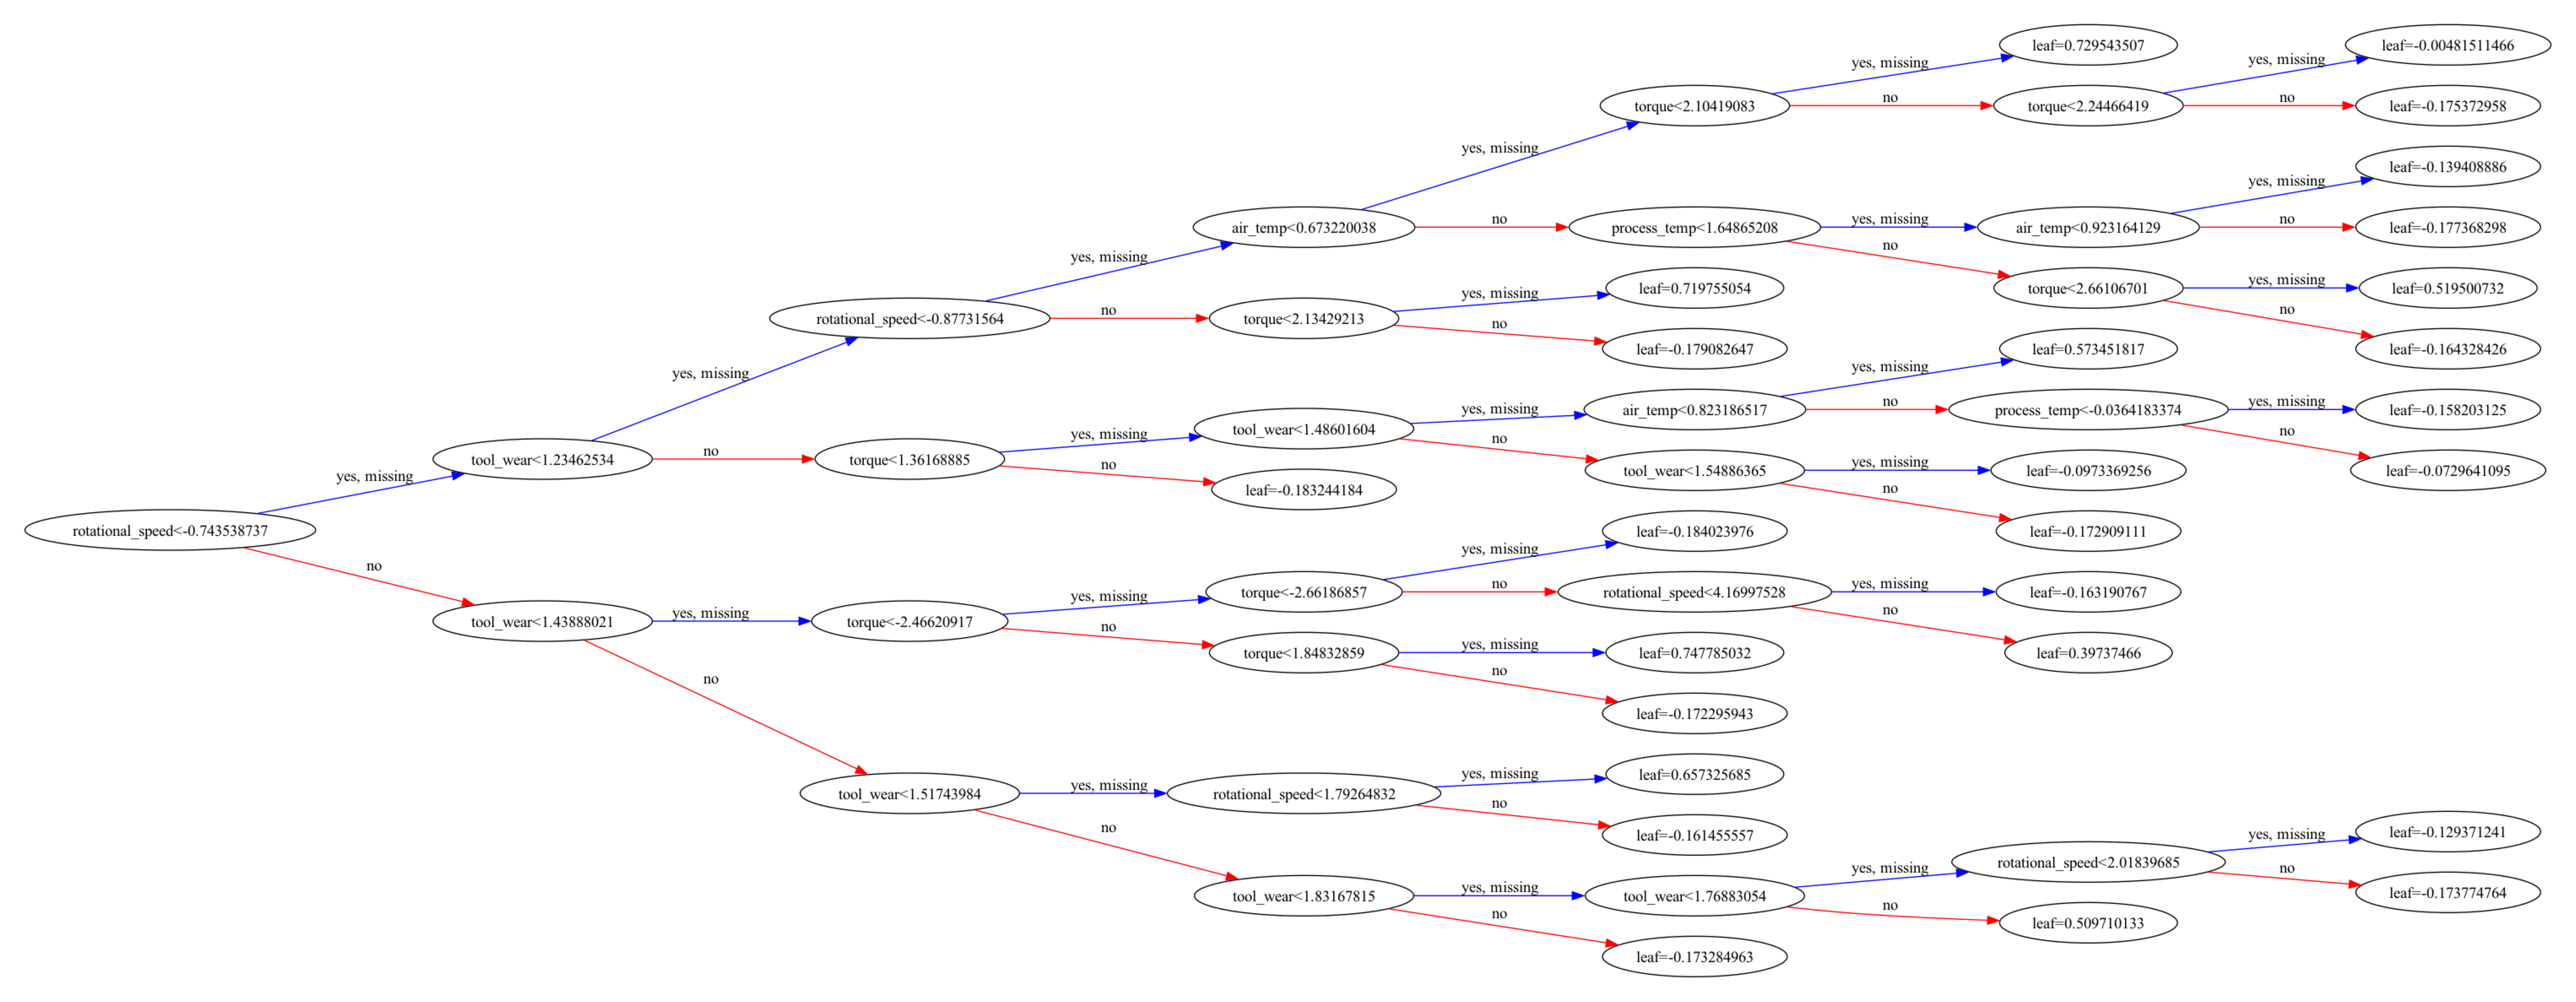

In [432]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 10), dpi=600)  # Adjust the figsize and dpi values according to your desired resolution
plot_tree(model, num_trees=0, rankdir='LR', ax=ax)
plt.show()


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


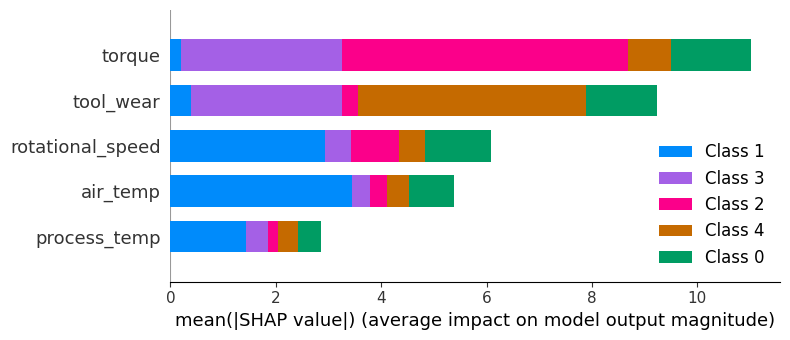

In [433]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [466]:
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Exact explainer: 2993it [00:35, 59.59it/s]                          


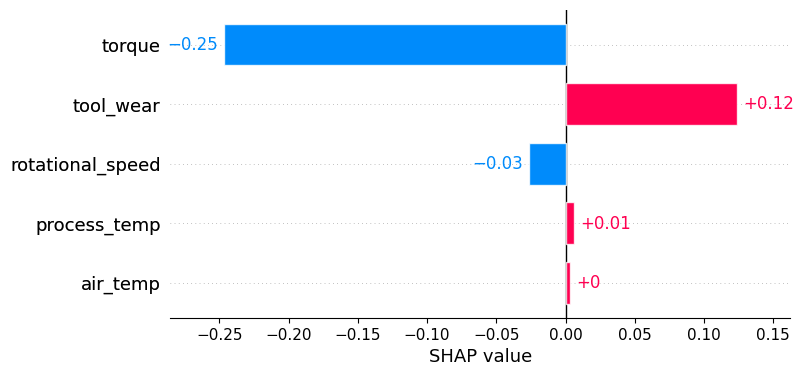

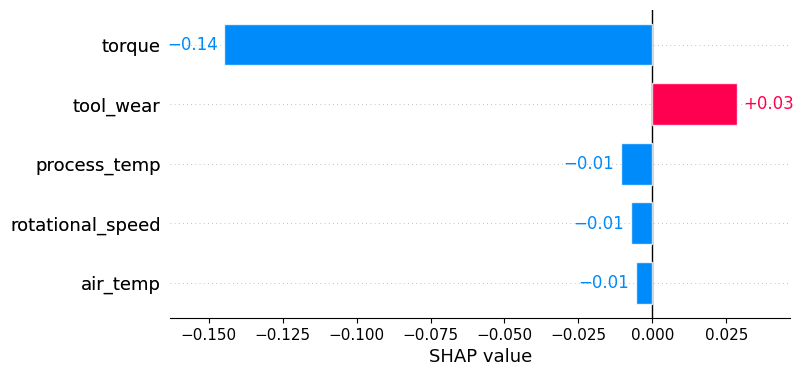

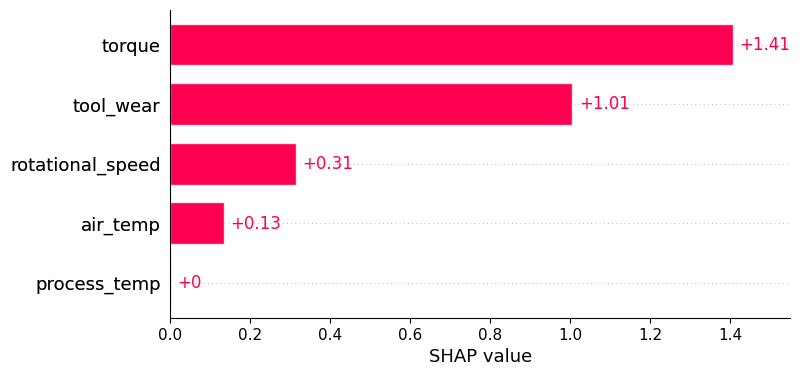

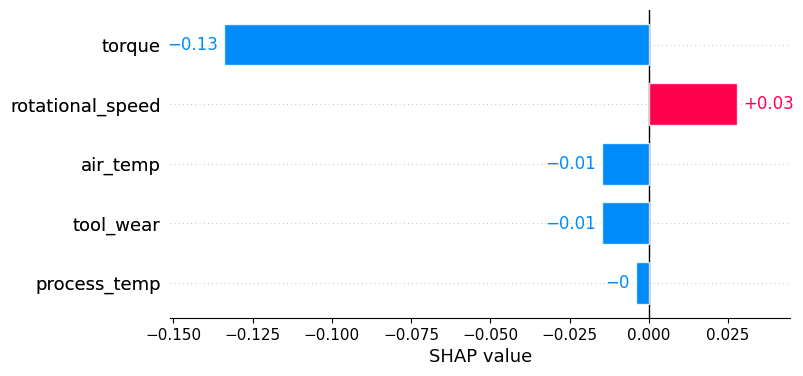

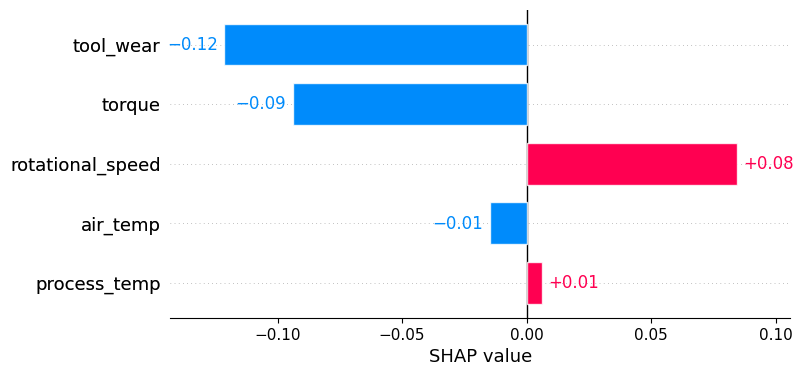

In [467]:
shap.plots.bar(shap_values[0])
shap.plots.bar(shap_values[1])
shap.plots.bar(shap_values[2])
shap.plots.bar(shap_values[3])
shap.plots.bar(shap_values[4])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


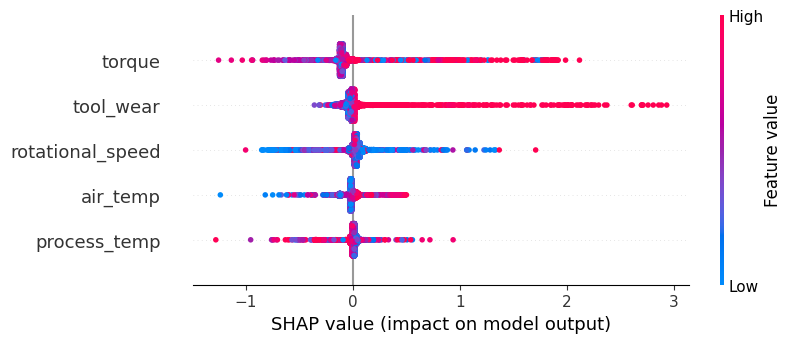

In [436]:
shap.plots.beeswarm(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


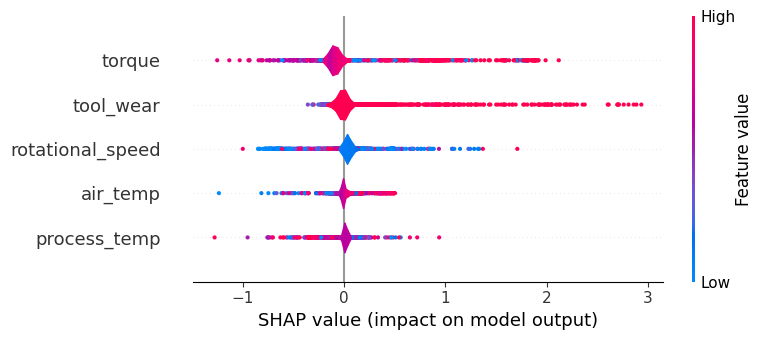

In [437]:
shap.summary_plot(shap_values, plot_type='violin')

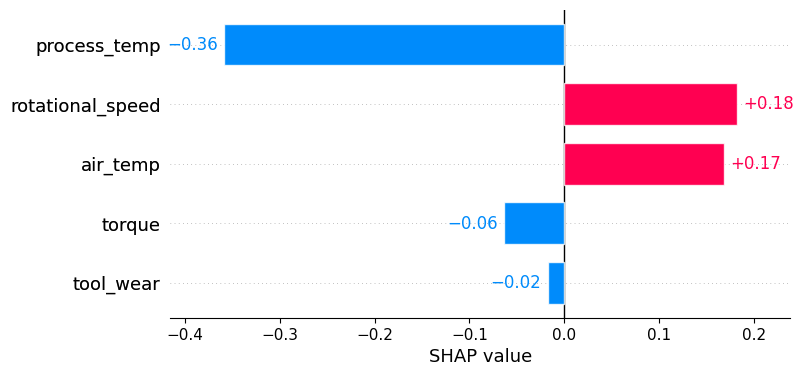

In [438]:
shap.plots.bar(shap_values[1])

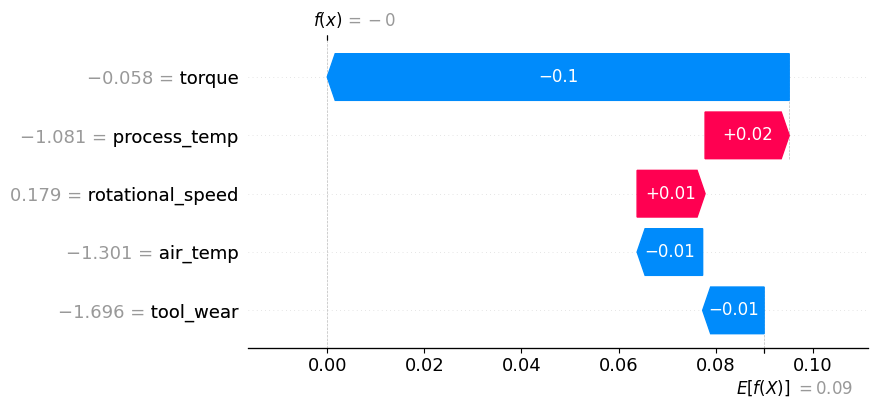

In [439]:
shap.plots.waterfall(shap_values[2])

In [449]:
shap.plots.force(shap_values[1])

In [514]:
import lime
import lime.lime_tabular

In [518]:
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train.values, feature_names=X_train.columns, class_names=['No Failure', 'Heat Dissipation Failure', 'Power Failure', 'Overstrain Failure', 'Tool Wear Failure'], discretize_continuous=True)

In [519]:
import numpy as np
import lime
import lime.lime_tabular

np.random.seed(123)
predict_fn = lambda x: model.predict_proba(x)

# Defining the LIME explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(df[['Torque [Nm]', 'rotational speed', 'air temperature', 'process temperature', 'tool wear time']].astype(int).values,
                                                   mode='classification',
                                                   class_names=['No Failure', 'Heat Dissipation Failure', 'Power Failure', 'Overstrain Failure', 'Tool Wear Failure'],
                                                   training_labels=df['Churn'],
                                                   feature_names=['torque', 'rotational speed', 'air temperature', 'process temperature', 'tool wear time'])

# Using LIME to get the explanations
i = 5
exp = explainer.explain_instance(df.loc[i, ['torque', 'rotational speed', 'air temperature', 'process temperature', 'tool wear time']].astype(int).values, predict_fn, num_features=5)
exp.show_in_notebook(show_table=True)


KeyError: "['rotational speed', 'air temperature', 'process temperature', 'tool wear time'] not in index"

In [520]:
instance_index = 2991  # Choose the index of the instance to explain
instance = X_test.iloc[[instance_index]]

explanation = explainer.explain_instance(instance.values[0], model.predict_proba, num_features=len(X_train.columns))


In [512]:
from IPython.display import display, HTML

# Display the explanation as HTML
html = explanation.as_html(show_table=True)
display(HTML(html))


# Display the explanation as HTML
html = explanation.as_html(show_table=True)
display(HTML(html))

In [445]:
explanation.as_list()

[('air_temp > 0.75', 0.15217499755241545),
 ('rotational_speed <= -0.65', 0.14353861381380176),
 ('0.02 < tool_wear <= 0.87', -0.0029137252627057324),
 ('torque > 0.68', 0.002544816445195636),
 ('0.06 < process_temp <= 0.74', 0.001965635559141622)]

In [446]:
lime.plots.bar(lime_values[0])

AttributeError: module 'lime' has no attribute 'plots'

In [ ]:
explanation.as_map()

{1: [(2, -0.05058950827761069),
  (0, -0.04665793966527515),
  (3, -0.00782039589432475),
  (1, -0.00220612885753157),
  (4, 0.00036985760158966027)]}

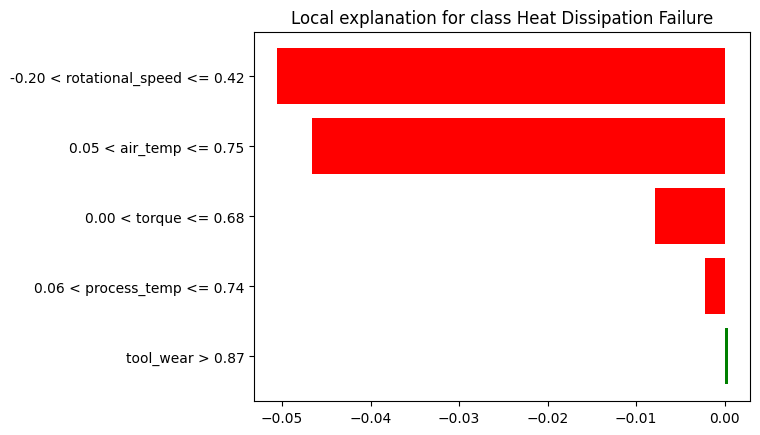

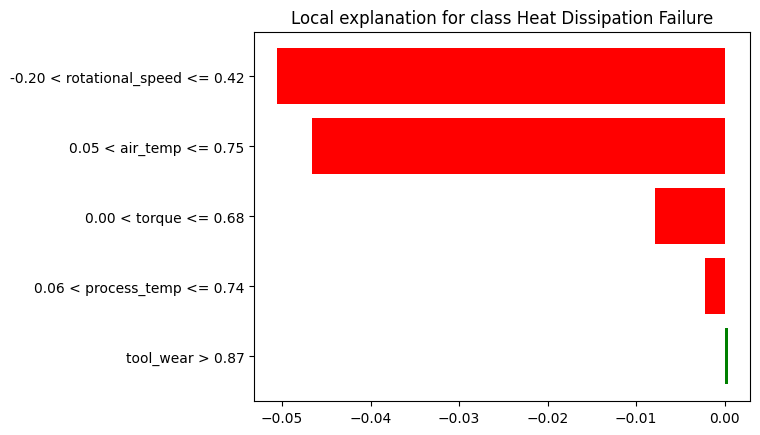

In [ ]:
explanation.as_pyplot_figure()